In [2]:
import pandas as pd
import datetime as dt

In [910]:
df = pd.read_csv("Crimes_-_2001_to_present.csv")

In [911]:
# drop rows without location
df = df[df['Latitude'].notna()]

In [912]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3,10179775,HY368117,01/01/2015 12:00:00 AM,022XX S SAWYER AVE,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,APARTMENT,False,True,...,12.0,30,02,1155042.0,1888945.0,2015,04/04/2020 03:44:34 PM,41.851074,-87.706450,"(41.851074338, -87.706449961)"
13,9993839,HY183887,01/01/2015 12:00:00 AM,068XX S PAULINA ST,1541,OBSCENITY,SALE/DIST OBSCENE MAT TO MINOR,RESIDENCE,False,True,...,17.0,67,26,1166188.0,1859423.0,2015,10/10/2019 04:11:30 PM,41.769832,-87.666383,"(41.769832073, -87.666382614)"
76,10004791,HY194724,01/01/2015 12:00:00 AM,075XX S STEWART AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,...,17.0,69,20,1174930.0,1855016.0,2015,02/10/2018 03:50:01 PM,41.757548,-87.634470,"(41.757548256, -87.634469566)"
77,10024172,HY212630,01/01/2015 12:00:00 AM,078XX S MAY ST,1753,OFFENSE INVOLVING CHILDREN,SEX ASSLT OF CHILD BY FAM MBR,RESIDENCE,False,False,...,17.0,71,02,1170011.0,1852871.0,2015,02/10/2018 03:50:01 PM,41.751770,-87.652559,"(41.751770335, -87.65255922)"
78,10024814,HY210309,01/01/2015 12:00:00 AM,077XX S LANGLEY AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,6.0,69,17,1182238.0,1853779.0,2015,02/10/2018 03:50:01 PM,41.753988,-87.607725,"(41.753987764, -87.607725188)"


In [913]:
#Cleaning Dependent Variable (Primary Type)

df['Primary Type'].unique()

#Grouping together crimes that that are relatively similar 
for crime in ['CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE', 'CRIM SEXUAL ASSAULT']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'SEX CRIMES'
for crime in ['NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON-CRIMINAL']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'NON-CRIMINAL'
for crime in ['BATTERY', 'ASSAULT']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'BATTERY/ASSAULT'
for crime in ['THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'THEFT RELATED'

Text(0.5, 0, 'Crime Type')

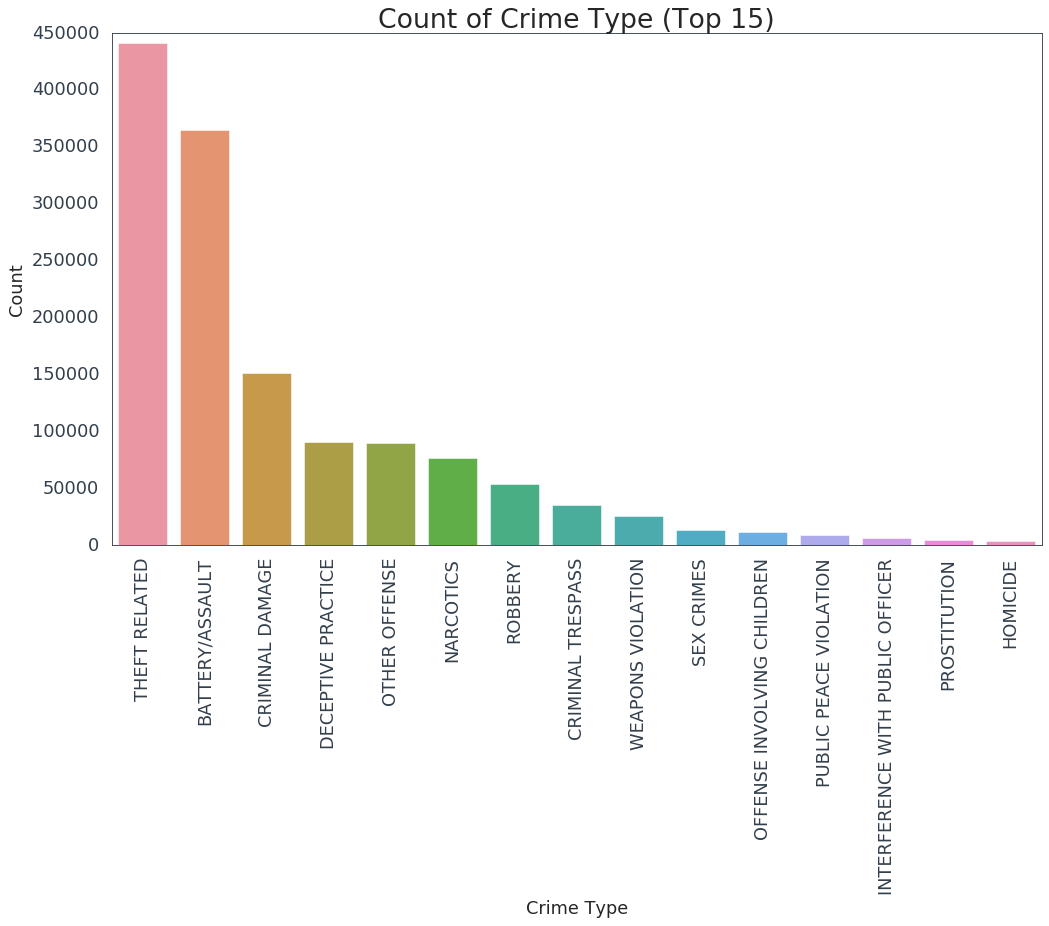

In [914]:
count_crime_types = df.groupby('Primary Type').count()
count_crime_types['Count Number'] = count_crime_types['ID']
count_crime_types = count_crime_types['Count Number']
crime_count_df = count_crime_types.reset_index()
top15_crimes = crime_count_df.sort_values(by='Count Number', ascending=False).head(15)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.barplot(top15_crimes['Primary Type'], top15_crimes['Count Number'])
plt.xticks(rotation=90)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime Type (Top 15)', fontsize=24)
ax.set_xlabel('Crime Type', fontsize=16)

In [915]:
#selecting only rows where 'Primary Type' is part of the Top 15 list of crimes in Chicago
crime_list = list(top15_crimes['Primary Type'].unique())
df = df[df['Primary Type'].isin(crime_list)]

#diving primary type into violent and non violent crimes. 
#division of 
for crime in ['SEX CRIMES', 'OFFENSE INVOLVING CHILDREN', 'BATTERY/ASSAULT', 'WEAPONS VIOLATION', 'NARCOTICS','INTERFERENCE WITH PUBLIC OFFICER', 'ROBBERY', 'HOMICIDE', 'PUBLIC PEACE VIOLATION']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'VIOLENT CRIME'
for crime in ['THEFT RELATED', 'DECEPTIVE PRACTICE', 'OTHER OFFENSE', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'PROSTITUTION']:
    df['Primary Type'].loc[(df['Primary Type'] == crime)] = 'NON VIOLENT CRIME'
    
    
    

Text(0.5, 0, 'Crime Type')

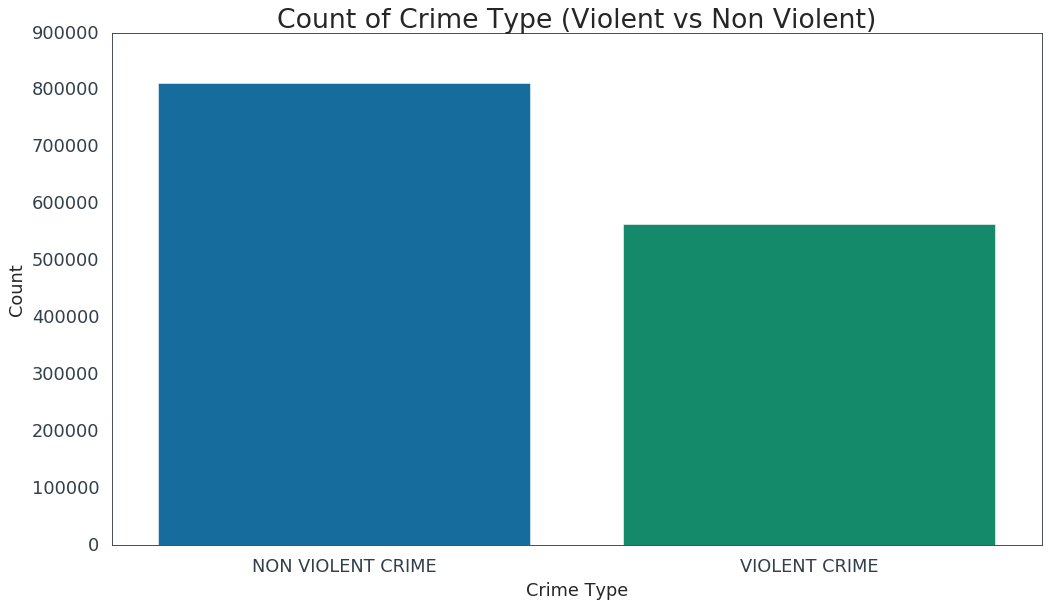

In [916]:
import matplotlib.pyplot as plt
import seaborn as sns
count_crime_types = df.groupby('Primary Type').count()
count_crime_types['Count Number'] = count_crime_types['ID']
count_crime_types = count_crime_types['Count Number']
crime_count_df = count_crime_types.reset_index()

plt.figure(figsize=(15,8))
ax = sns.barplot(crime_count_df['Primary Type'], crime_count_df['Count Number'])
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime Type (Violent vs Non Violent)', fontsize=24)
ax.set_xlabel('Crime Type', fontsize=16)

In [921]:
import geopandas as gpd
from geopandas import GeoDataFrame

#district = gpd.read_file("Boundaries-Neighborhoods.geojson")
gcrime = gpd.GeoDataFrame(df, geometry = \
                          gpd.points_from_xy(x=df['Longitude'], y=df['Latitude']))
gcrime.crs = {'init' :'epsg:4326'}
crime = gpd.sjoin(gcrime, district, how="left", op="within")

#only want rows where there is a pri_neigh which would be an important feature for our multiclass model later 
crime_df = crime[crime['pri_neigh'].notna()]

/Users/dominicteo/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dominicteo/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [194]:
# Total population: B02001_001E; Total White: B02001_002E; Total Black: B02001_003E; Median income: B19013_001E;
# Median age: B01002_001E; Below 100 percent of the poverty level: B07012_002E, Median contract rent: B25058_001E; 
acs = censusdata.download("acs5", 2015, censusdata.censusgeo(
    [("state", "17"), ("county", "031"), ("block group", "*")]), \
    ["B02001_001E", 'B02001_002E', 'B02001_003E', 'B19013_001E', "B01002_001E", "GEO_ID"])

In [195]:
acs.columns = ['Total Population', 'Total White Population', 'Total Black Population', 'Median Income', 'Median Age',  'GEO_ID']
acs['Percent White'] = acs['Total White Population']/acs['Total Population']
acs['Percent Black'] = acs['Total Black Population']/acs['Total Population']
acs = acs.iloc[:, 3:]
acs["geo_12"] = acs["GEO_ID"].map(lambda x: str(x)[-12:])




,Median Income,Median Age,GEO_ID,Percent White,Percent Black
"Block Group 1, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:1",110833.0,30.2,1500000US170310202001,0.853569,0.008830
"Block Group 2, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:2",29038.0,33.4,1500000US170310202002,0.484578,0.302947
"Block Group 3, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:3",102026.0,39.9,1500000US170310202003,0.820750,0.000000
"Block Group 4, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:4",60918.0,46.5,1500000US170310202004,0.340253,0.180253
"Block Group 1, Census Tract 203.01, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020301> block group:1",46276.0,59.5,1500000US170310203011,0.827044,0.061006
...,...,...,...,...,...
"Block Group 1, Census Tract 6606, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:660600> block group:1",34063.0,29.4,1500000US170316606001,0.050877,0.792105
"Block Group 2, Census Tract 6606, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:660600> block group:2",21987.0,28.1,1500000US170316606002,0.052553,0.947447
"Block Group 3, Census Tract 6606, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:660600> block group:3",26890.0,28.7,1500000US170316606003,0.162838,0.618243
"Block Group 4, Census Tract 6606, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:660600> block group:4",24387.0,31.8,1500000US170316606004,0.164384,0.412916


In [903]:
acs.head()

,Median Income,Median Age,GEO_ID,Percent White,Percent Black,geo_12
"Block Group 1, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:1",110833.0,30.2,1500000US170310202001,0.853569,0.008830,170310202001
"Block Group 2, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:2",29038.0,33.4,1500000US170310202002,0.484578,0.302947,170310202002
"Block Group 3, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:3",102026.0,39.9,1500000US170310202003,0.820750,0.000000,170310202003
"Block Group 4, Census Tract 202, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020200> block group:4",60918.0,46.5,1500000US170310202004,0.340253,0.180253,170310202004
"Block Group 1, Census Tract 203.01, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:020301> block group:1",46276.0,59.5,1500000US170310203011,0.827044,0.061006,170310203011


In [197]:
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
merged_gdf = (gpd.GeoDataFrame(acs.merge(census_gdf, on="geo_12", how="inner"), crs=crime.crs))

In [926]:
df = crime_df.drop(['index_right'], axis=1)
df = df.loc[:, ['Date', 'Primary Type', 'Location Description','Arrest', 'Domestic', 'geometry', 'pri_neigh']]
tdf = gpd.sjoin(df, merged_gdf, how="right", op='within')


In [930]:
ndf = tdf.loc[:, ['Date', 'Primary Type', 'Median Age', 'Median Income', 'Percent White', 'Percent Black', 'Location Description','Arrest', 'Domestic', 'geometry', 'geo_12', 'pri_neigh']]

#cleaning Location Description feature in dataset
#dropping rows without Location Description
ndf = ndf[ndf['Location Description'].notna()]

#Grouping together Locations that that are relatively similar 
for location in ['APARTMENT', 'RESIDENTIAL YARD (FRONT/BACK)', 'RESIDENCE PORCH/HALLWAY', 'RESIDENCE-GARAGE', 'CHA APARTMENT', 'DRIVEWAY - RESIDENTIAL']:
    ndf['Location Description'].loc[(ndf['Location Description'] == location)] = 'RESIDENCE'
for location in ['STREET', 'SIDEWALK', 'ALLEY']:
    ndf['Location Description'].loc[(ndf['Location Description'] == location)] = 'STREET'        

ndf['Location Description'].loc[ndf['Location Description'].str.contains("CTA")] = 'CTA PROPERTIES'
ndf['Location Description'].loc[ndf['Location Description'].str.contains("SCHOOL")] = 'SCHOOL'
ndf['Location Description'].loc[ndf['Location Description'].str.contains("COLLEGE")] = 'SCHOOL'
ndf['Location Description'].loc[ndf['Location Description'].str.contains("POLICE")] = 'POLICE PROPERTIES'
ndf['Location Description'].loc[ndf['Location Description'].str.contains("AIRPORT")] = 'AIRPORT PROPERTIES'
ndf['Location Description'].loc[ndf['Location Description'].str.contains("VEHICLE")] = 'VEHICLE'

#select rows that fall within the top 25 locations
location_list = list(ndf['Location Description'].unique()[:25])
ndf = ndf[ndf['Location Description'].isin(location_list)]    



In [932]:
#cleaning the data

#8 geo_12s where 'Percent White' and 'Percent Black' is NaN and Median Income is negative. Difficult to simply replace
#with median so we decide to drop it instead.

wrong = list(ndf[ndf['Percent White'].isna()]['geo_12'].unique())
ndf = ndf[~ndf['Percent White'].isin(wrong)]

#11 geo_12s where 'Median Income' is still negative so we replace it with median of the column
ndf['Median Income'].loc[(ndf['Median Income'] < 0)] = ndf['Median Income'].median()


In [936]:
ndf['Date'] = pd.to_datetime(ndf["Date"], format='%m/%d/%Y %I:%M:%S %p')
def find_weekday(time):
    return int(time.strftime("%w"))

#for weekday, 0 represents Sunday, 1 represents Monday and so on
ndf['day'] = ndf['Date'].apply(find_weekday)
ndf['hour'] = ndf['Date'].dt.hour
ndf['month'] = ndf['Date'].dt.month
ndf['year'] = ndf['Date'].dt.year
ndf['date'] = ndf['Date'].dt.day

In [939]:
#converting day into weekday vs weekend
for day in [1,2,3,4,5]:
    ndf['day'].loc[(ndf['day'] == day)] = 'WEEKDAY'
for day in [0,6]:
    ndf['day'].loc[(ndf['day'] == day)] = 'WEEKEND'

In [941]:
# merge weather data
weather = pd.read_csv('2162082.csv')

In [942]:
weather.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
0,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",2015-01-01,0.00,0.0,0.0,32,17
1,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",2015-01-02,0.00,0.0,0.0,36,20
2,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",2015-01-03,0.59,0.3,0.0,37,31
3,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",2015-01-04,0.18,1.6,2.0,36,5
4,USC00111577,"CHICAGO MIDWAY AIRPORT 3 SW, IL US",2015-01-05,0.15,2.3,4.0,10,-1


In [993]:
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')
weather['year'] = weather['DATE'].dt.year
weather['month'] = weather['DATE'].dt.month
weather['date'] = weather['DATE'].dt.day
merged_df = ndf.merge(weather, on=['month', 'year', 'date'])
merged_df = merged_df.drop(['geometry', 'Date', 'STATION', 'NAME', 'DATE', 'year','geo_12', 'Arrest', 'Domestic', 'date'], axis=1)

In [945]:
#data cleaning steps 

#transform binary boolean columns into integers
merged_df['Arrest'] = merged_df['Arrest'].astype(int)
merged_df['Domestic'] = merged_df['Domestic'].astype(int)

#one hot encoding for categorical features 
from sklearn.preprocessing import OneHotEncoder
merged_df[['hour', 'month', 'date']]=merged_df[['hour', 'month', 'date']].astype(str)
categorical_variables = ['Location Description', 'pri_neigh', 'hour', 'month']
categorical_features = pd.get_dummies(merged_df[categorical_variables])
merged_df = pd.concat([merged_df[['Primary Type','Median Age', 'Median Income', 'Percent White',
       'Percent Black','Arrest', 'Domestic','PRCP','SNOW', 'SNWD', 'TMAX', 'TMIN', 'day']], categorical_features], axis=1, join='inner')

In [949]:
merged_df.to_csv('crime.csv')

In [543]:
#Feautres: Median Age, Median Income, Percent White, Percent Black, Arrest, Domestic, PRCP, Snow, SNWD, TMAX, TMIN, Date, Hour, Month, Weekday, pri_neigh, location


In [950]:
reduced_sample = merged_df.sample(frac=0.1, replace=True, random_state=1)
reduced_sample.to_csv('crime_reduced.csv')

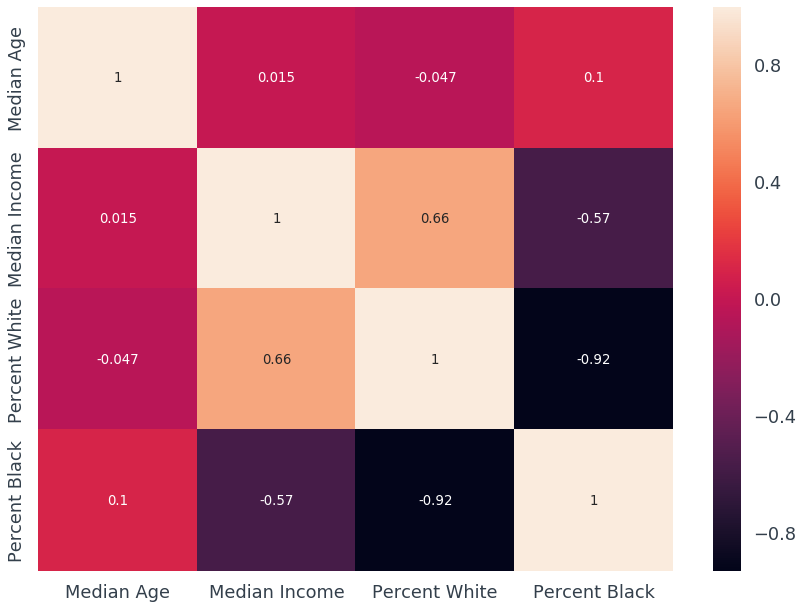

In [793]:
#Data Visualisations and Exploration 

#Correlation heat map of contiuous Variables
continuous = ndf[['Median Age', 'Median Income', 'Percent White', 'Percent Black']]
corrMatrix = continuous.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

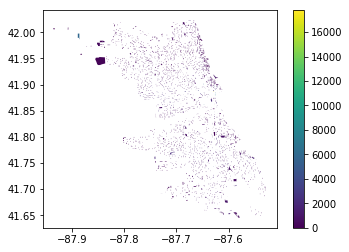

In [616]:
crime_count.plot(column='Primary Type', legend=True)

Text(0.5, 1.0, 'Distribution of Violent Crime')

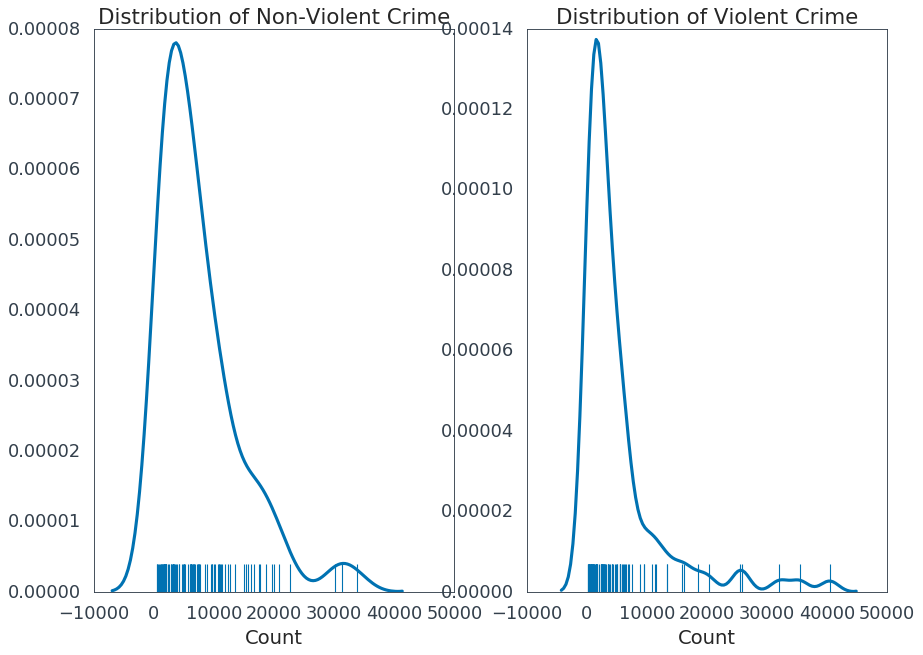

In [988]:
neigh_crime = ndf[['pri_neigh', 'Primary Type', 'geo_12']]
violent = neigh_crime[neigh_crime['Primary Type']=='VIOLENT CRIME']
non_violent = neigh_crime[neigh_crime['Primary Type']=='NON VIOLENT CRIME']
v = violent.groupby(['pri_neigh'])['geo_12'].size().reset_index()
v.columns = ['Primary Neighborhood', 'Count']
v.sort_values(by='Count').head(10)
n = non_violent.groupby(['pri_neigh'])['geo_12'].size().reset_index()
n.columns = ['Primary Neighborhood', 'Count']
fig, ax =plt.subplots(1,2)
sns.distplot(n['Count'], hist=False, rug=True, ax=ax[0]).set_title('Distribution of Non-Violent Crime')
sns.distplot(v['Count'], hist=False, rug=True, ax=ax[1]).set_title('Distribution of Violent Crime')

Text(0.5, 0, 'Weekday')

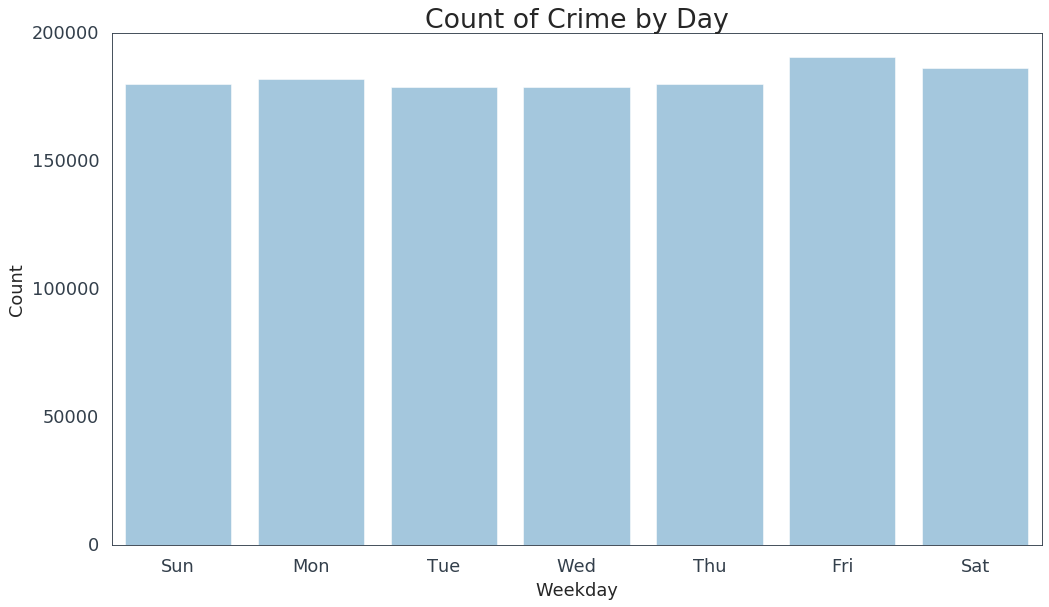

In [954]:
# determining if there is any relation between day, month and hour to the number of crime committed 

time_df = ndf[['Primary Type', 'weekday', 'hour', 'month', 'date']]
day = time_df.groupby('weekday').count().rename(index={0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'})['Primary Type'].reset_index()
day.columns = ['Weekday', 'Count']
plt.figure(figsize=(15,8))
ax = sns.barplot(day['Weekday'], day['Count'], color='lightskyblue', saturation=0.5)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime by Day', fontsize=24)
ax.set_xlabel('Weekday', fontsize=16)

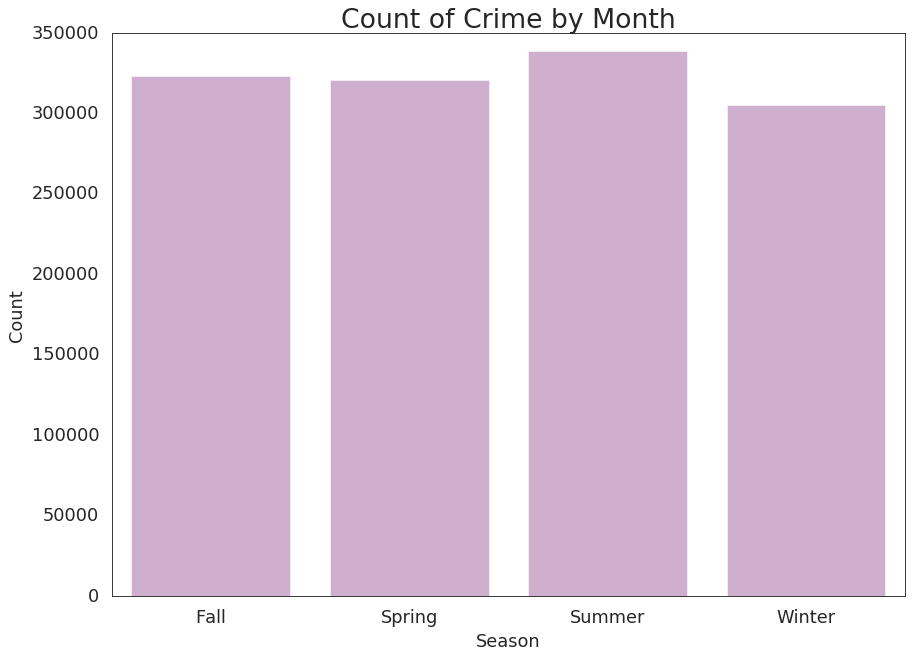

In [779]:
#Winter (Nov, Dec, Jan) appears to have significantly lower crime than the other seasons with Summer (May, Jun, Jul) 
#having most crime reported

month = time_df.groupby('month').count()['Primary Type'].reset_index()
month.columns = ['Month', 'Count']
month['season'] = pd.Series(['Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter', 'Winter'])
season = month.groupby('season').sum()['Count'].reset_index()

sns.set_style('white', {'font.family': ['Helvitca']})
ax = sns.barplot(season['season'], season['Count'], color='plum', saturation=0.5)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime by Month', fontsize=24)
ax.set_xlabel('Season', fontsize=16)
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [789]:
dff = time_df.groupby(['hour', 'Primary Type'])['date'].size()
dff2 = dff.reset_index(level='Primary Type')
l = []
for i in range(24):
    l.append((dff2.loc[i, :].sort_values(by='date', ascending=False).iloc[0], dff2.loc[i, :].sort_values(by='date', ascending=False).iloc[1]))

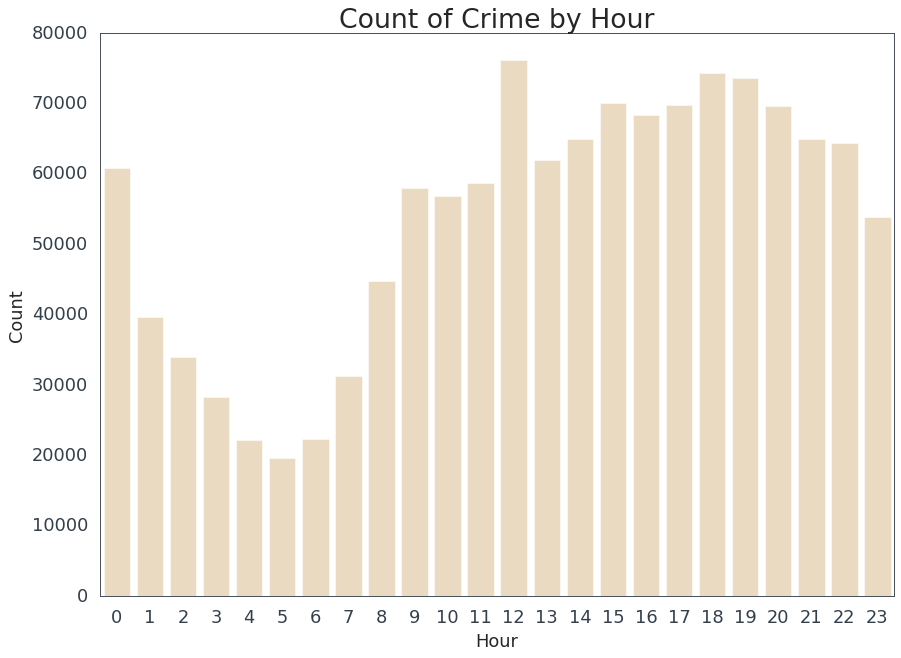

In [951]:
#Number of crime peaks at Noon and tapers off significantly at 2300H until 0500H where it begins to pick up again.
#There is a significant fall in crime after 0000H. 

hour = time_df.groupby('hour').count()['Primary Type'].reset_index()
hour.columns = ['Hour', 'Count']

ax = sns.barplot(hour['Hour'], hour['Count'], color='navajowhite', saturation=0.5)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime by Hour', fontsize=24)
ax.set_xlabel('Hour', fontsize=16)
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

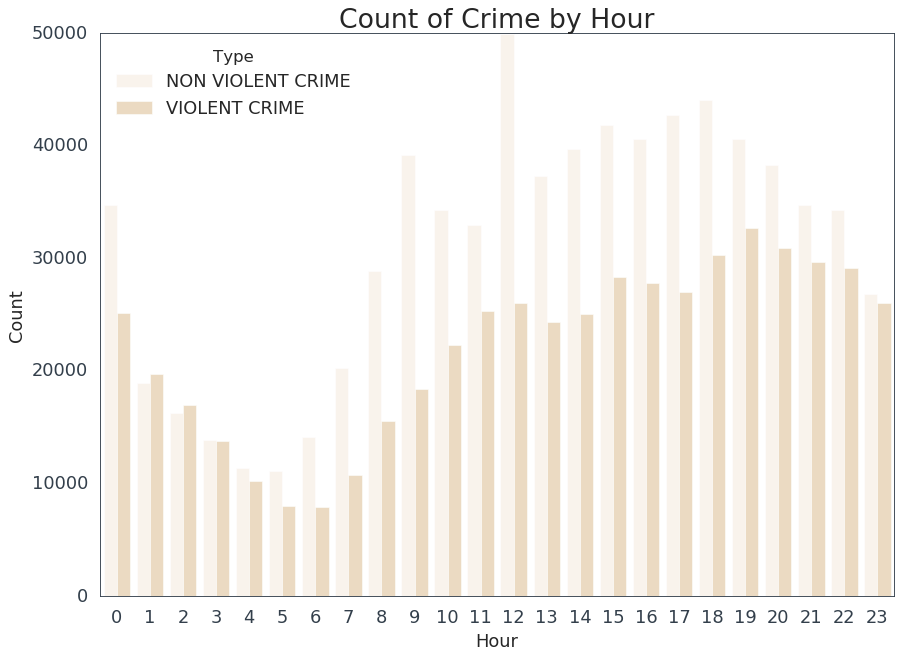

In [962]:
hour = time_df.groupby(['hour', 'Primary Type']).count()['weekday'].reset_index()
hour.columns = ['Hour', 'Type','Count']
ax = sns.barplot(x='Hour', y='Count', color='navajowhite', hue='Type', saturation=0.5, data=hour)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Crime by Hour', fontsize=24)
ax.set_xlabel('Hour', fontsize=16)
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [847]:
a = ndf[['Arrest', 'Primary Type', 'Domestic']].groupby(['Primary Type', 'Arrest']).count()
a['percentage'] = 0
for i in range(len(a)):
    if i%2==0:
        a['percentage'].iloc[i] = a['Domestic'].iloc[i]/(a['Domestic'].iloc[i] + a['Domestic'].iloc[i+1])
    elif i%2==1:
        a['percentage'].iloc[i] = a['Domestic'].iloc[i]/(a['Domestic'].iloc[i] + a['Domestic'].iloc[i-1])

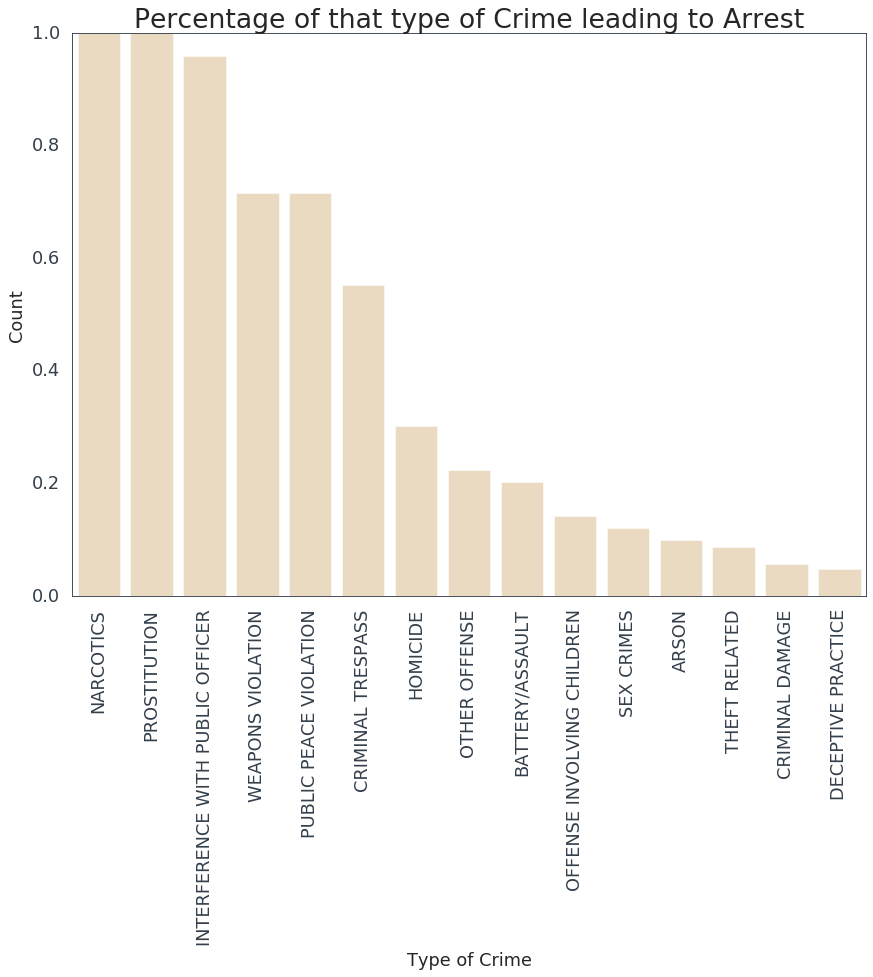

In [856]:
arrest = pd.DataFrame(a['percentage']).reset_index()
arrest = arrest[arrest['Arrest']==True].sort_values(by='percentage', ascending=False)

ax = sns.barplot(arrest['Primary Type'], arrest['percentage'], color='navajowhite', saturation=0.5)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Percentage of that type of Crime leading to Arrest', fontsize=24)
ax.set_xlabel('Type of Crime', fontsize=16)
plt.xticks(rotation=90)
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [875]:
a = ndf.copy()
a.drop(['geometry', 'geo_12'], axis=1)

,Date,Primary Type,Median Age,Median Income,Percent White,Percent Black,Location Description,Arrest,Domestic,pri_neigh_x,weekday,hour,month,year,date
0,2017-12-25 23:25:00,BATTERY/ASSAULT,30.2,110833.0,0.853569,0.008830,RESIDENCE,False,True,West Ridge,1,23,12,2017,25
0,2018-11-27 00:00:00,THEFT RELATED,30.2,110833.0,0.853569,0.008830,STREET,False,False,West Ridge,2,0,11,2018,27
0,2016-09-22 22:00:00,THEFT RELATED,30.2,110833.0,0.853569,0.008830,STREET,False,False,West Ridge,4,22,9,2016,22
0,2019-12-18 17:30:00,THEFT RELATED,30.2,110833.0,0.853569,0.008830,STREET,False,False,West Ridge,3,17,12,2019,18
0,2016-08-05 11:00:00,THEFT RELATED,30.2,110833.0,0.853569,0.008830,RESIDENCE,False,False,West Ridge,5,11,8,2016,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46356,2020-01-16 14:30:00,BATTERY/ASSAULT,39.3,33527.0,0.193154,0.516707,RESIDENCE,False,True,Chicago Lawn,4,14,1,2020,16
46356,2016-11-14 19:30:00,BATTERY/ASSAULT,39.3,33527.0,0.193154,0.516707,STREET,False,False,Chicago Lawn,1,19,11,2016,14
46356,2016-05-18 20:00:00,THEFT RELATED,39.3,33527.0,0.193154,0.516707,STREET,False,False,Chicago Lawn,3,20,5,2016,18
46356,2018-09-28 09:00:00,BATTERY/ASSAULT,39.3,33527.0,0.193154,0.516707,RESIDENCE,False,True,Chicago Lawn,5,9,9,2018,28
